# Visualization with Cytoscape

The matrix view of the network has the benefit of a deterministic automated layout. Cytoscape offers an alternative view that offers more aesthetic options to highlight different network features.

### Import common modules

In [13]:
from py2cytoscape.data.cynetwork import CyNetwork
from py2cytoscape.data.cyrest_client import CyRestClient
from py2cytoscape.data.style import StyleUtil
import py2cytoscape.util.cytoscapejs as cyjs
import py2cytoscape.cytoscapejs as renderer

from IPython.display import Image

import igraph as igraph

from sand.csv import csv_to_dicts
import sand.graph as sg
import sand.cytoscape.positions as scp
import sand.cytoscape.app as app
from sand.cytoscape.themes import ops, colors
import sand.groups as groups

### Load the dataset as a weighted edge list

In [14]:
network_collection = "lein-topology"
network_name = "57af741"

data_path = "./data/" + network_collection + "-" + network_name

In [15]:
edge_file = data_path + ".csv"
edgelist = csv_to_dicts(edge_file,header=['source', 'target', 'weight'])
g = sg.from_edges(edgelist)
g.summary()

'IGRAPH DNW- 107 206 -- \n+ attr: group (v), indegree (v), label (v), name (v), outdegree (v), weight (e)'

## Community Detection / Clustering

Namespaces are the modules of the system and will serve as groups / communities in the visualization.

In [16]:
g.vs['group'] = groups.labels_to_groups(g.vs['label'])
g.vs['namespace'] = groups.namespaces(g.vs['label'])

## Extract the subgraph of local namespaces 

There are some analyses where it will be useful to see all the vertices. For the high-level architecture diagram, we can focus on the functions local to the library's namespaces. We'll also keep functions that have side-effects to see if these are isolated to only a few key parts of the program:

In [17]:
# List all patterns of vertex names that we want to keep:
names_to_keep = ('topology', 'clojure.core/*err*', 'clojure.core/println')

lv = g.vs(lambda v: any(match in v['label'] for match in names_to_keep))
lg = g.subgraph(lv)

# Recompute degree after building the subgraph:
lg.vs['indegree'] = lg.degree(mode="in")
lg.vs['outdegree'] = lg.degree(mode="out")

lg.summary()

'IGRAPH DNW- 26 26 -- \n+ attr: group (v), indegree (v), label (v), name (v), namespace (v), outdegree (v), weight (e)'

# Visualizing the network in Cytoscape

## Verify that Cytoscape is running and get the current version

In [18]:
app.print_version()

{
  "apiVersion": "v1",
  "cytoscapeVersion": "3.5.1"
}


## Load into Cytoscape with a default layout

In [19]:
# Create py2cytoscape client
cy = CyRestClient()

In [20]:
# Optional: delete all existing networks
cy.session.delete()

In [21]:
# Load the network
network = cy.network.create_from_igraph(lg, name=network_name, collection=network_collection)

## Customize the style

Use one of the included themes, or build your own.

In [22]:
style = cy.style.create('Ops')
style.update_defaults(ops.settings)

# Map the label property in the igraph data to Cytoscape's NODE_LABEL visual property
style.create_passthrough_mapping(column='label', vp='NODE_LABEL', col_type='String')

### Give each group a unique color.

In [23]:
border_colors = {
  'topology.finder': colors.BRIGHT_YELLOW,
  'topology.dependencies': colors.BRIGHT_ORANGE,
  'topology.dependencies-test': colors.BRIGHT_ORANGE,
  'topology.qualifier': colors.BRIGHT_PURPLE,
  'topology.symbols': colors.BRIGHT_BLUE,
  'clojure.core': colors.BRIGHT_RED,
  'topology.printer': colors.BRIGHT_RED,
  'leiningen.topology': colors.BRIGHT_WHITE,
}

fill_colors = {
  'topology.finder': colors.DARK_YELLOW,
  'topology.dependencies': colors.DARK_ORANGE,
  'topology.dependencies-test': colors.DARK_ORANGE,
  'topology.qualifier': colors.DARK_PURPLE,
  'topology.symbols': colors.DARK_BLUE,
  'clojure.core': colors.DARK_RED,
  'topology.printer': colors.DARK_RED,
  'leiningen.topology': colors.DARK_WHITE,
}

style.create_discrete_mapping(column='namespace', col_type='String', vp='NODE_FILL_COLOR', mappings=fill_colors)
style.create_discrete_mapping(column='namespace', col_type='String', vp='NODE_BORDER_PAINT', mappings=border_colors)

In [24]:
cy.style.apply(style, network)

## Layout

In [25]:
# Apply default layout
cy.layout.apply(name='force-directed', network=network)

In [26]:
# Load layout coordinates from a previous session
positions_file = data_path + "-positions.csv"
scp.layout_from_positions_csv(network, positions_file, cy)

## Save the updated layout coordinates if you make changes

One benefit of this workflow is the ability to manually tweak the algorithmic network layout in Cytoscape.

After making changes, save the coordinates for a later session:

In [27]:
scp.positions_to_csv(network=network, path=positions_file)

## Generate an SVG export

Position the network in Cytoscape the way you want it, then trigger this export.
When iterating, run all cells above, then all cells below this point to avoid race conditions with cytoscape's renderer.

In [28]:
# Hide all panels in the UI
app.hide_panels()

True

In [29]:
# Fit to the window:
cy.layout.fit(network=network)

In [30]:
view_id = network.get_views()[0]

In [31]:
view = network.get_view(view_id=view_id, format='view')

In [32]:
# Zoom out slightly:
view.update_network_view('NETWORK_SCALE_FACTOR', 0.7)

In [33]:
# Shift the network to the left:
view.update_network_view('NETWORK_CENTER_X_LOCATION', 750.0)

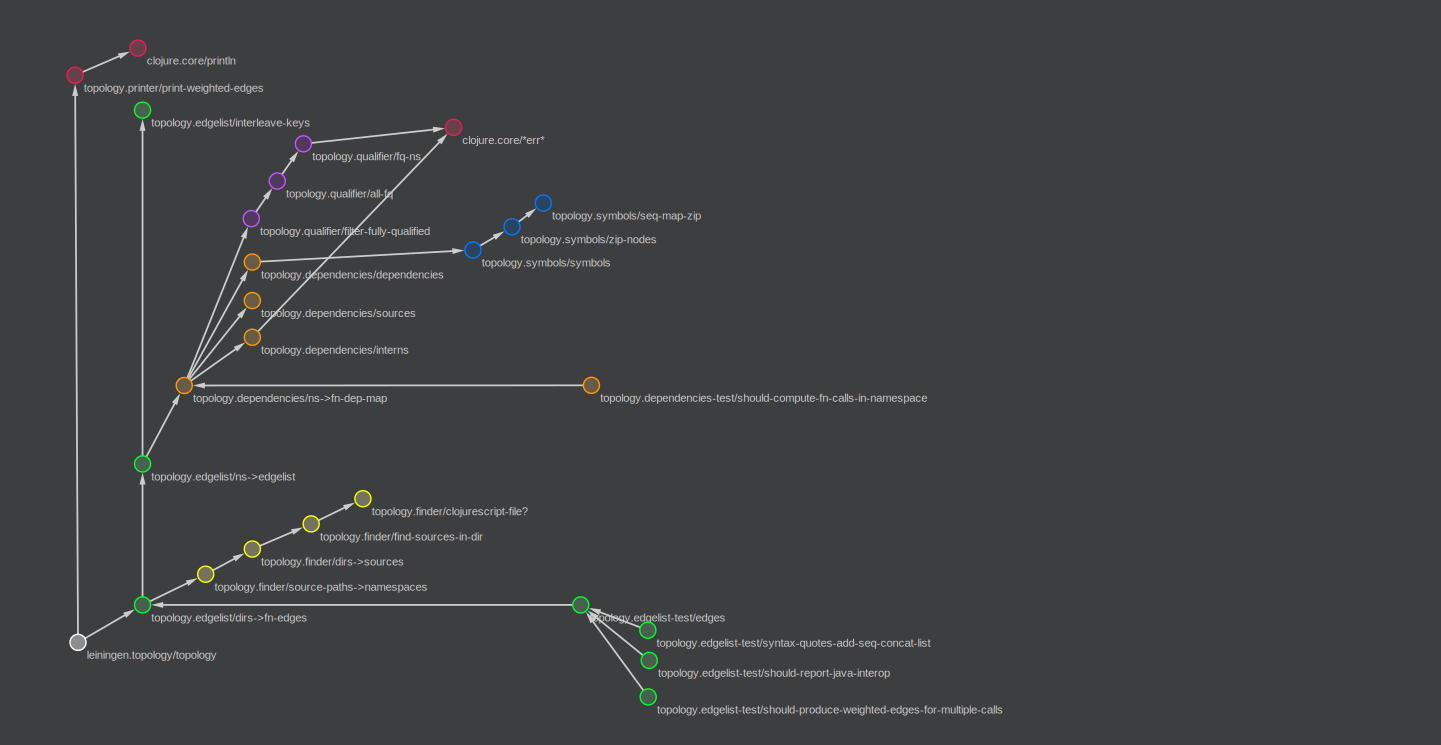

In [34]:
from IPython.display import SVG, display

svg_data = network.get_svg()
display(SVG(svg_data))

In [35]:
# Write the svg to a file if everything looks good:
with open(data_path + '.svg', 'wb') as f:
    f.write(svg_data)

### To create an updated structure after making new commits:

- Generate an updated network.
- Copy the previous position file to use as a starting point for the next visualization.
- Open Cytoscape or destroy existing collections if Cytoscape is already running.
- Run all cells to load the visualization.
- Save the new layout if you make changes.